In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
from random import randrange
from PIL import Image
import os
import random
from sklearn.decomposition import TruncatedSVD #importing just to do truncatedSVD for me, I didn't have the time(and energy :) ) to implement by myself.

In [2]:
data = pd.read_csv('health_data.csv')
data.head()

,age,restbps,chol,category
0,26,109,243,0
1,27,106,156,0
2,28,107,225,0
3,27,105,277,0
4,30,96,221,0


In [3]:
X = data.to_numpy()[:, :]

In [4]:
##k-Cross_validation_split:
def cross_validation_split(dataset,k):
    k_folds = list()
    copy_data = list(dataset)
    fold_size = int(len(dataset)/k)
    
    for i in range(k):
        fold = list()
        for j in range(fold_size):
            fold.append(copy_data.pop(randrange(len(copy_data))))
        k_folds.append(fold)
    return k_folds    

In [ ]:
X = data.to_numpy()[:, :3]
Y = data.to_numpy()[:, 3]
split = 0.8 #using 70:30 split, random each time
train_samples = np.random.choice(X.shape[0], int(split*X.shape[0]))
test_samples = np.array([i for i in range(X.shape[0]) if i not in list(train_samples)])

X_train = X[[train_samples]]
Y_train = Y[[train_samples]]

X_test = X[[test_samples]]
Y_test = Y[[test_samples]]


X_0 = X_train[Y_train == 0]
X_1 = X_train[Y_train == 1]



X_test_0 = X_test[Y_test == 0]
X_test_1 = X_test[Y_test==1]


# Naive_Bayes_Classifier_with_Gaussian_Prior

In [5]:
#mean function
def mean(data):
    return sum(data)/float(len(data))

In [6]:
#variance function
def std(data):
    mu  = mean(data)
    return math.sqrt(sum([(x - mu)**2 for x in data])/float(len(data) - 1))

In [7]:
#stat of class 0(Maximum Likelihood Estimate)
def statistics_0(X_0):
    stat_X0 = [(mean(col),  std(col)) for col in zip(*X_0)]
    return stat_X0

In [8]:
#stat of class 1(Maximum Likelihood Estimate)
def statistics_1(X_1):
    stat_X1 = [(mean(col),  std(col)) for col in zip(*X_1)]
    return stat_X1

In [9]:
def statistics(X_class):
    stat_X_class = [(mean(col),  std(col)) for col in zip(*X_class)]
    return stat_X_class

In [10]:
stat = [statistics(X_0), statistics(X_1)]

NameError: name 'X_0' is not defined

In [11]:
#Probability calculation
def Normal_dist(x, mean, std):
    return (1 / (math.sqrt(2 * math.pi) * std)) *math.exp(-((x-mean)**2 / (2 * std**2 )))

In [12]:
#prior calculation
def prior(X_0, X_1):
    P = [float(len(X_0))/ float(len(X_0) + len(X_1)) ,float(len(X_1))/ float(len(X_0) + len(X_1)) ]
    return P

In [ ]:
P = prior(X_0, X_1)

In [13]:
def prior_multi_class(X, no_of_classes):
    P = []
    for i in range(no_of_classes):
        X_i = X[X ==i]
        P.append(float(X_i.shape[0]/X.shape[0]))
    return P

In [14]:
#calculation of class conditional density
def class_conditional_probability(data, stat, no_of_classes):
    probabilities = np.ones(no_of_classes, dtype = np.float64)
    for i in range(no_of_classes):
        for j in range(len(stat[i])):
            mean, stdev = stat[i][j]
            #print( Normal_dist(data[i], mean, stdev))
            probabilities[i] *= Normal_dist(data[j], mean, stdev)
    return probabilities

In [15]:
#calculation of posterior
def posterior(data, stat, P, no_of_classes):
    prob = np.zeros(no_of_classes, dtype = np.float64)
    probabilities = class_conditional_probability(data, stat, no_of_classes)
    #print(probabilities)
    for i in range(no_of_classes):
        prob[i] = probabilities[i]*P[i]
    return prob

In [16]:
def prediction(data, stat,P, Th, no_of_classes):
    Probabilities = posterior(data, stat, P, no_of_classes)
    Probabilities = Probabilities/sum(Probabilities)
    #print(Probabilities)
    if Probabilities[1] > Th:
        return 1
    else:
        return 0

In [83]:
def prediction_multi_class(data, stat,P, Th, no_of_classes):
    Probabilities = posterior(data, stat, P, no_of_classes)
    Probabilities = Probabilities/sum(Probabilities)
    #print(Probabilities)
    y_prediction = np.zeros(no_of_classes)
    y_prediction[np.argmax(np.array(Probabilities))] = 1
    return y_prediction

In [ ]:
from tqdm import tqdm
TP = []
FP = []
accuracy = []
precision = []
recall = []
f1_score = []
no_of_classes = 2
for p0 in tqdm(np.linspace(0.000000001,0.999999999999,1000)):
    C = np.zeros((2,2)) #[[]]
    for i in range((X_test_0.shape[0])):
        y_pred = prediction(X_test_0[i], stat, P, p0, no_of_classes)
        C[y_pred, 0] += 1
    for i in range((X_test_1.shape[0])):
        y_pred = prediction(X_test_1[i], stat, P, p0,no_of_classes)
        C[y_pred, 1] += 1
    
    tpr = C[1,1]/(C[1,1] + C[0,1])
    fpr = C[1,0]/(C[1,0] + C[0,0])
    acc = (C[0,0] + C[1,1])/np.sum(C) 
    pr = C[1,1]/(C[1,1] + C[1,0])
    rec = C[1,1]/(C[1,1] + C[0,1])
    f1 = 2*(pr*rec)/(pr + rec)
    precision.append(pr)
    recall.append(rec)
    f1_score.append(f1)
    accuracy.append(acc)
    TP.append(tpr)
    FP.append(fpr)

plt.plot(FP, TP, '-')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC curve');

In [ ]:
plt.plot(np.linspace(0.000000001,0.999999999999,1000), accuracy, '-')
plt.xlabel('prior'); plt.ylabel('ACCURACY'); plt.title('ACCURACY VS prior');

In [ ]:
plt.plot(np.linspace(0.000000001,0.999999999999,1000), recall, '-')
plt.xlabel('prior'); plt.ylabel('RECALL'); plt.title('RECALL VS prior');

In [ ]:
plt.plot(np.linspace(0.000000001,0.999999999999,1000), precision, '-')
plt.xlabel('prior'); plt.ylabel('PRECISION'); plt.title('PRECISION VS prior');

In [ ]:
plt.plot(np.linspace(0.000000001,0.999999999999,1000), f1_score, '-')
plt.xlabel('prior'); plt.ylabel('F1_SCORE'); plt.title('F1_SCORE VS prior');

# k-fold evaluation

In [ ]:
from tqdm import tqdm

In [ ]:
def k_fold_evaluation(dataset, no_of_folds):
    k_folds = cross_validation_split(dataset, no_of_folds)
    accuracy_list = []
    TP_rate_list = []
    FP_rate_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    ind = 0
    for fold in k_folds:
        
        X_train = list(k_folds)
        #print(ind)
        del X_train[ind]
        ind=ind+1
        X_train = sum(X_train, [])
        X_train = np.array(X_train)
        X_0 = X_train[X_train[:,3] == 0]
        X_1 = X_train[X_train[:,3] == 1]
        stat = [statistics_0(X_0[:,:3]),statistics_1(X_1[:,:3])]
        fold = np.array(fold)
        X_test_0 = fold[fold[:,3] == 0]
        X_test_1 = fold[fold[:,3] == 1]
        P = prior(X_0, X_1)
        for i in range((X_test_0.shape[0])):
            y_pred = prediction(X_test_0[i], stat, P, 0.5,2)
            C[y_pred, 0] += 1
        for i in range((X_test_1.shape[0])):
            y_pred = prediction(X_test_1[i], stat, P, 0.5,2)
            C[y_pred, 1] += 1
        acc = (C[0,0] + C[1,1])/np.sum(C) 
        pr = C[1,1]/(C[1,1] + C[1,0])
        rec = C[1,1]/(C[1,1] + C[0,1])
        f1 = 2*(pr*rec)/(pr + rec)
        accuracy_list.append(acc)
        precision_list.append(pr)
        recall_list.append(rec)
        f1_score_list.append(f1)
    return np.mean(np.array(accuracy_list)), np.mean(np.array(TP_rate_list)), np.mean(np.array(FP_rate_list)), np.mean(np.array(precision_list)), np.mean(np.array(recall_list)), np.mean(np.array(f1_score_list)) 
    

In [ ]:
accuracy_list, TP_rate_list, FP_rate_list, precision_list, recall_list, f1_score_list = k_fold_evaluation(X, 5)
print(accuracy_list)
print(precision_list)
print(recall_list)
print(f1_score_list)

In [ ]:
accuracy = []
precision = []
recall = []
f1_score = []
for k in range(2,40):
    accuracy_list, TP_rate_list, FP_rate_list, precision_list, recall_list, f1_score_list = k_fold_evaluation(X, k)
    #print("for " + str(k) + " fold results of evaluation metric")
    #print(accuracy_list)
    #print(precision_list)
    #print(recall_list)
    #print(f1_score_list)
    accuracy.append(accuracy_list)
    precision.append(precision_list)
    recall.append(recall_list)
    f1_score.append(f1_score_list)

In [ ]:
plt.plot(range(2,40), accuracy, '-')
plt.xlabel('no_of_folds'); plt.ylabel('ACCURACY'); plt.title('ACCURACY VS k');

In [ ]:
plt.plot(range(2,40), precision, '-')
plt.xlabel('no_of_folds'); plt.ylabel('precision'); plt.title('precision VS k');

In [ ]:
plt.plot(range(2,40), recall, '-')
plt.xlabel('no_of_folds'); plt.ylabel('recall'); plt.title('recall VS k');

In [ ]:
plt.plot(range(2,40), f1_score, '-')
plt.xlabel('no_of_folds'); plt.ylabel('f1_score'); plt.title('F1_score VS k');

## question 3

In [18]:
import os
IMAGE_PATH = './Medical_MNIST'
print(os.path.abspath(IMAGE_PATH))
n_components = 20

C:\Users\rockt\Assignment1_git\ELL409_Assignment1\Medical_MNIST


In [19]:
#data_loader
#!DEL *.npz
from tqdm import tqdm
split = 0.7 #using 70:30 split, random each time
def data_loader():
    X = []
    Y = []
    X_test = []
    Y_test = []
    
    i = 0
    for folder in os.listdir(os.path.abspath(IMAGE_PATH)):
        IMAGE_DIR = os.path.join(IMAGE_PATH, folder)
        print("Reading" + IMAGE_DIR)
        files = os.listdir(IMAGE_DIR)
        random.shuffle(files)
        j=0
        for file in tqdm(files):
            if j < int(len(files)*split):
                X.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
                Y.append(i)
            else:
                X_test.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
                Y_test.append(i)
            j += 1
        
        i += 1
    print('Completed Loading Data. Saving as np file so that can directy load array nexttime')
    np.savez('q3data.npz', X = np.array(X), Y = np.array(Y), X_test=X_test, Y_test = Y_test)
    return np.array(X), np.array(Y), np.array(X_test), np.array(Y_test)

if 'q3data.npz' in os.listdir('./'):
    zfile = np.load('q3data.npz')
    X = zfile['X']
    Y = zfile['Y']
    X_test = zfile['X_test']
    Y_test = zfile['Y_test']
else:
    X, Y, X_test, Y_test = data_loader()

In [20]:
print(f'X.shape = {X.shape}') #oof!
print(f'X_test.shape = {X_test.shape}')

X.shape = (41267, 4096)
X_test.shape = (17687, 4096)


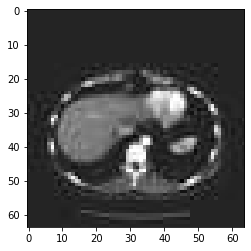

In [21]:
#Visualizing the images.
plt.imshow(X[0].reshape(64, -1), cmap='gray')

In [22]:
#Lets try to do PCA on the input images??
h, w = 64, 64
'''
def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return projected, components, mean, centered_data
    #credits to https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184 for helping me write PCA
    #and saving me a few hours.
'''
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
'''
n_components = 50
P, C, M, X_centered=pca(X[:1000], n_pc=n_components)
#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 
'''

'\nn_components = 50\nP, C, M, X_centered=pca(X[:1000], n_pc=n_components)\n#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)\neigenscans = C.reshape((n_components, h, w))\neigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]\nplot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) \n'

In [44]:
X_samples = list()
Y_samples = list()
X_samples.append(list(X))
Y_samples.append(list(Y))
X_samples.append(list(X_test))
Y_samples.append(list(Y_test))
X_samples = sum(X_samples, [])
Y_samples = sum(Y_samples, [])
X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

In [23]:
def fastpca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    svd = TruncatedSVD(n_components=n_pc, n_iter=7, random_state=42)
    svd.fit(X)
    #U, S, V = np.linalg.svd(centered_data)
    components = svd.components_
    #projected = U[:,:n_pc]*S[:n_pc]
    projected = svd.transform(X)
    return projected, components, mean, centered_data

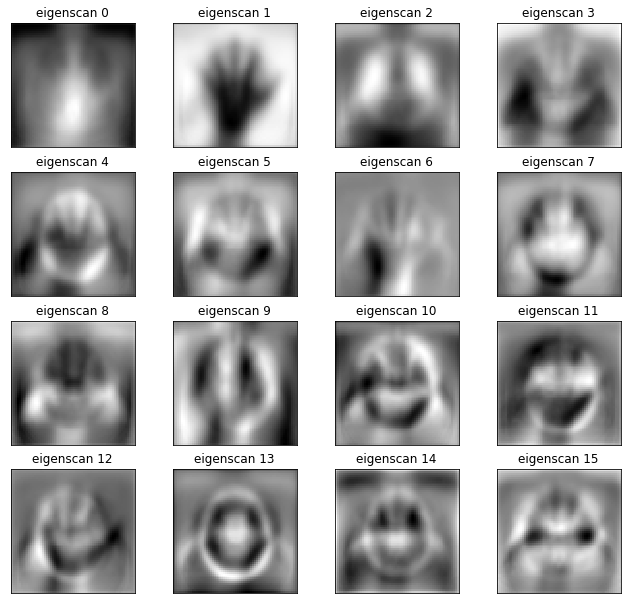

In [34]:
X_red, C, M, X_centered=fastpca(X_samples, n_pc=n_components)
#X_red->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 

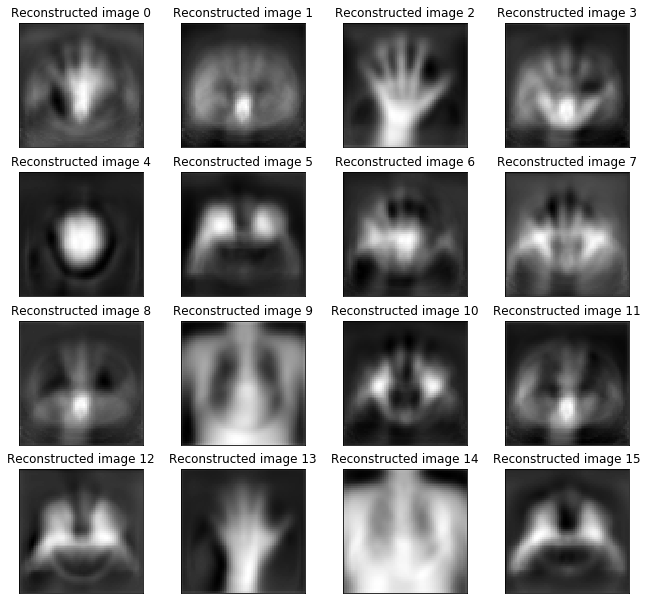

In [35]:
def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image
arr = np.random.choice(X.shape[0], 16)
recovered_images=[reconstruction(X_centered, C, M, h, w, i) for i in arr]
plot_portraits(recovered_images, [f"Reconstructed image {i}" for i in range(len(recovered_images))], h, w, n_row=4, n_col=4)

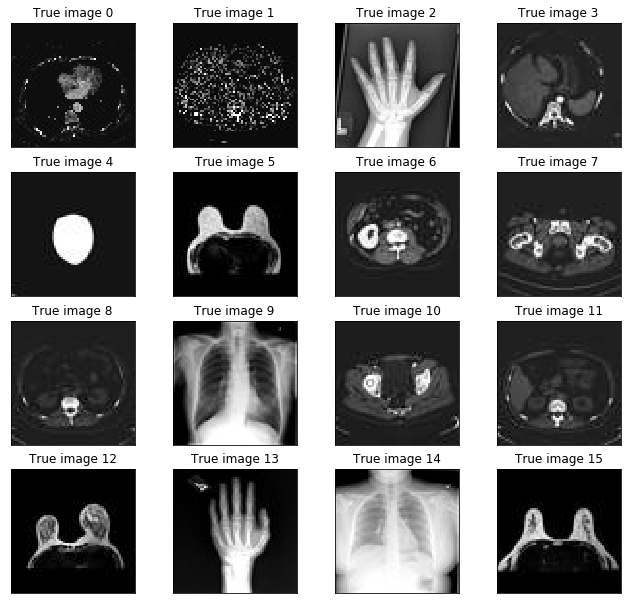

In [36]:
true_images = [X[i].reshape(h, w) for i in arr]
plot_portraits(true_images, [f"True image {i}" for i in range(len(recovered_images))], h, w, n_row=4, n_col=4)

In [41]:
X_red.shape

(58954, 20)

In [43]:
X_samples.shape

(58954, 4096)

In [54]:
Y_samples.shape

(58954,)

In [60]:
Y_samples = Y_samples.reshape((58954,1))


In [61]:
X_final = np.append(X_red, Y_samples, axis = 1)
X_final.shape

(58954, 21)

In [37]:
no_of_classes = 6


In [38]:
Prior = prior_multi_class((Y), no_of_classes)

In [72]:
def separate(X, no_of_classes):
    data = dict()
    for i in range(no_of_classes):
        data["X_"+str(i)] = X[X[:,20] == i]
        data["stat_"+str(i)] = statistics(X[X[:,20]==i][:, :20])
    return data

In [73]:
data = separate(X_final, 6)

In [74]:
data["stat_0"]

[(7171.190756180064, 342.86111779586133),
 (735.1747929041142, 175.30999658337655),
 (871.1471446684463, 246.8628687431925),
 (374.75456562226844, 216.8558335762043),
 (-139.23428826175905, 130.22888665559694),
 (-70.73168903078803, 195.0345487650291),
 (-16.56697870858497, 119.43170426961284),
 (81.36748521552262, 196.44852212969826),
 (147.57754007071804, 205.9958922681113),
 (-27.546278137411363, 77.45838427323375),
 (-18.004415821858544, 127.64224796082826),
 (-22.772968169702303, 179.6980242920911),
 (-51.69603345266882, 150.63029206697774),
 (-5.488352807586543, 163.6795405056349),
 (87.14148915907757, 150.3220465742263),
 (93.08927449837654, 214.18434018015338),
 (23.225956233719252, 119.62831754787786),
 (19.26670331317168, 120.83427484980236),
 (77.61286591643557, 171.28495766680447),
 (-16.536001915960433, 152.91315125979213)]

k_fold = cross_validation_split(X_final, 4)
np.array(k_fold).shape

In [78]:
stat = []
for ff in range(6):
    stat.append(data["stat_"+str(ff)])
print(np.array(stat).shape)

(6, 20, 2)


In [104]:
def k_fold_evaluation_multi_class(dataset, no_of_folds, no_of_classes, no_of_features,prior):
    k_folds = cross_validation_split(dataset, no_of_folds)
    accuracy_list = []
    TP_rate_list = []
    FP_rate_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    ind = 0
    for fold in k_folds:
        
        X_train = list(k_folds)
        #print(ind)
        del X_train[ind]
        ind=ind+1
        X_train = sum(X_train, [])
        X_train = np.array(X_train)
        data_train = separate(X_train, no_of_classes)
        stat = []
        for ff in range(no_of_classes):
            stat.append(data_train["stat_"+str(ff)])
        fold = np.array(fold)
        data_test = separate(fold, no_of_classes)
        Y = X_train[:,20].reshape(X_train.shape[0])
        P = prior_multi_class((Y), no_of_classes)
        C = np.zeros((no_of_classes,no_of_classes))
        for cc in range(no_of_classes):
            X_test = data_test["X_"+str(cc)]
            for i in range((X_test.shape[0])):
                y_pred = prediction_multi_class(X_test[i], stat,P, 0.5, no_of_classes)
                C[np.argmax(np.array(y_pred)), cc] += 1
        if ind == 1:
            print(C)
            print("no_of_elements" + str(np.sum(C)))
        acc = (C[0,0] + C[1,1]+ C[2,2]+ C[3,3]+ C[4,4]+ C[5,5])/np.sum(C) 
        #pr = C[1,1]/(C[1,1] + C[1,0])
        #rec = C[1,1]/(C[1,1] + C[0,1])
        #f1 = 2*(pr*rec)/(pr + rec)
        accuracy_list.append(acc)
        #precision_list.append(pr)
        #recall_list.append(rec)
        #f1_score_list.append(f1)
    return np.array(accuracy_list), np.mean(np.array(TP_rate_list)), np.mean(np.array(FP_rate_list)), np.mean(np.array(precision_list)), np.mean(np.array(recall_list)), np.mean(np.array(f1_score_list)) 
    

In [105]:
accuracy_list, TP_rate_list, FP_rate_list, precision_list, recall_list, f1_score_list = k_fold_evaluation_multi_class(X_final, 5,6,20,Prior)
print(accuracy_list)
print(np.mean(accuracy_list))

[[1.972e+03 0.000e+00 1.700e+01 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 1.744e+03 0.000e+00 0.000e+00 1.000e+00 1.190e+02]
 [0.000e+00 0.000e+00 1.985e+03 0.000e+00 0.000e+00 0.000e+00]
 [1.800e+01 0.000e+00 0.000e+00 1.982e+03 9.500e+01 0.000e+00]
 [2.000e+00 0.000e+00 0.000e+00 1.800e+01 1.892e+03 2.200e+01]
 [0.000e+00 9.000e+00 0.000e+00 1.100e+01 6.200e+01 1.841e+03]]
no_of_elements11790.0
[0.9682782  0.96675148 0.96810857 0.96598813 0.97175573]
0.9681764206955046


In [106]:
accuracy_list, TP_rate_list, FP_rate_list, precision_list, recall_list, f1_score_list = k_fold_evaluation_multi_class(X_final, 10,6,20,Prior)
print(accuracy_list)
print(np.mean(accuracy_list))

[[1007.    0.   12.    0.    0.    0.]
 [   0.  911.    0.    0.    0.   74.]
 [   0.    0.  969.    0.    0.    0.]
 [  15.    0.    0. 1000.   48.    0.]
 [   2.    0.    0.   10.  901.    7.]
 [   0.    8.    0.    2.   25.  904.]]
no_of_elements5895.0
[0.96556404 0.97251908 0.96980492 0.96658185 0.96658185 0.96793893
 0.97048346 0.9677693  0.9682782  0.96658185]
0.9682103477523325
